## Cookbook: Parallelized *STRUCTURE* analyses on unlinked SNPs

As part of the `ipyrad.analysis` toolkit we've created convenience functions for easily distributing *STRUCTURE* analysis jobs on an HPC cluster, and for doing so in a programmatic and reproducible way. Importantly, *our workflow allows you to easily sample different distributions of unlinked SNPs among replicate analyses*, with the final inferred population structure summarized from a distribution of replicates. We also provide some simple interactive plotting functions to make barplots and slightly fancier figure, like below. 

### A note on Jupyter/IPython
This is a Jupyter notebook, a reproducible and executable document. The code in this notebook is Python (2.7), and should be executed either in a jupyter-notebook, like this one, or in an IPython terminal. Execute each cell in order to reproduce our entire analysis. We make use of the `ipyparallel` Python library to distribute *STRUCTURE* jobs across processers in parallel. If that is confusing, see our [tutorial on using ipcluster with jupyter](). The example data set used in this analysis is from the [empirical example ipyrad tutorial](http://ipyrad.readthedocs.io/pedicularis_.html).

### Required software
You can easily install the required software for this notebook locally using `conda` by running the commented code below in a terminal. If you are working on an HPC cluster you **do not need** administrator privileges to install the software in this way, since it is only installed locally.

In [1]:
## conda install ipyrad -c ipyrad
## conda install structure -c ipyrad
## conda install clumpp -c ipyrad
## conda install toytree -c eaton-lab

### Import Python libraries

In [2]:
import ipyrad.analysis as ipa      ## ipyrad analysis toolkit
import ipyparallel as ipp          ## parallel processing
import toyplot                     ## plotting library

### Parallel cluster setup
Start an `ipcluster` instance in a separate terminal. An easy way to do this in a jupyter-notebook running on an HPC cluster is to go to your Jupyter dashboard, and click [new], and then [terminal], and run '`ipcluster start`' in that terminal. This will start a local cluster on the compute node you are connected to. See our [ipyparallel tutorial] (coming soon) for further details. 

In [3]:
##
## ipcluster start --n=40
##

In [5]:
## get parallel client
ipyclient = ipp.Client()
print "Connected to {} cores".format(len(ipyclient))

Connected to 56 cores


### Enter input and output file locations

In [6]:
## the structure formatted file
strfile = "./erisor.str"

## an optional mapfile, to sample unlinked SNPs
mapfile = "./erisor.snps.map"

## the directory where outfiles should be written
workdir = "./"

### Create a *Structure* Class object
Structure is kind of an old fashioned program that requires creating quite a few input files to run, which makes it not very convenient to use in a programmatic and reproducible way. To work around this we've created a convenience wrapper object to make it easy to submit Structure jobs and to summarize their results. 

In [7]:
## create a Structure object
struct = ipa.structure(name="structure-test",
                       data=strfile, 
                       mapfile=mapfile,
                       workdir=workdir)

### Set parameter options for this object
Our Structure object will be used to submit jobs to the cluster. It has associated with it a name, a set of input files, and a large number of parameter settings. You can modify the parameters by setting them like below. You can also use tab-completion to see all of the available options, or print them like below. See the [full structure docs here](http://computing.bio.cam.ac.uk/local/doc/structure.pdf) for further details on the function of each parameter. In support of reproducibility, it is good practice to print both the mainparams and extraparams so it is clear which options you used. 

In [8]:
## set mainparams for object
struct.mainparams.burnin = 10000
struct.mainparams.numreps = 100000

## see all mainparams
print struct.mainparams

## see or set extraparams
print struct.extraparams

burnin             10000               
extracols          0                   
label              1                   
locdata            0                   
mapdistances       0                   
markernames        0                   
markovphase        0                   
missing            -9                  
notambiguous       -999                
numreps            100000              
onerowperind       0                   
phased             0                   
phaseinfo          0                   
phenotype          0                   
ploidy             2                   
popdata            0                   
popflag            0                   
recessivealleles   0                   

admburnin           500                 
alpha               1.0                 
alphamax            10.0                
alphapriora         1.0                 
alphapriorb         2.0                 
alphapropsd         0.025               
ancestdist          0            

### Submit jobs to run on the cluster
The function `run()` distributes jobs to run on the cluster and load-balances the parallel workload. It takes a number of arguments. The first, `kpop`, is the number of populations. The second, `nreps`, is the number of replicated runs to perform. Each rep has a different random seed, and if you entered a mapfile for your Structure object then it will subsample unlinked snps independently in each replicate. The `seed` argument can be used to make the replicate analyses reproducible. The `extraparams.seed` parameter will be generated from this for each replicate. And finally, provide it the `ipyclient` object that we created above. The structure object will store an *asynchronous results object* for each job that is submitted so that we can query whether the jobs are finished yet or not. Using a simple for-loop we'll submit 20 replicate jobs to run at four different values of K. 

In [9]:
## a range of K-values to test
tests = [2,3,4,5,6]

In [10]:
## submit batches of 20 replicate jobs for each value of K 
for kpop in tests:
    struct.run(
        kpop=kpop, 
        nreps=20, 
        seed=12345,
        ipyclient=ipyclient,
        )

submitted 20 structure jobs [structure-test-K-2]
submitted 20 structure jobs [structure-test-K-3]
submitted 20 structure jobs [structure-test-K-4]
submitted 20 structure jobs [structure-test-K-5]
submitted 20 structure jobs [structure-test-K-6]


### Track progress until finished
You can check for finished results by using the `get_clumpp_table()` function, which tries to summarize the finished results files. If no results are ready it will simply print a warning message telling you to wait. If you want the notebook to block/wait until all jobs are finished then execute the `wait()` function of the ipyclient object, like below. 

In [11]:
## see submitted jobs (we query first 10 here)
struct.asyncs[:10]

[<AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>]

In [9]:
## query a specific job result by index
if struct.asyncs[20].ready():
    print struct.asyncs[20].result()

IndexError: list index out of range

In [13]:
## block/wait until all jobs finished
ipyclient.wait() 

True

### Summarize replicates with CLUMPP
We ran 20 replicates per K-value hypothesis. We now need to concatenate and purmute those results so they can be summarized. For this we use the software clumpp. The default arguments to clumpp are generally good, but you can modify them the same as structure params, by accessing the `.clumppparams` attribute of your structure object. See the [clumpp documentation](https://web.stanford.edu/group/rosenberglab/software/CLUMPP_Manual.pdf) for more details. If you have a large number of samples (>50) you may wish to use the `largeKgreedy` algorithm (m=3) for faster runtimes. Below we run clumpp for each value of K that we ran structure on. You only need to tell the `get_clumpp_table()` function the value of K and it will find all of the result files given the Structure object's `name` and `workdir`.

In [10]:
## set some clumpp params
struct.clumppparams.m = 3               ## use largegreedy algorithm
struct.clumppparams.greedy_option = 2   ## test nrepeat possible orders
struct.clumppparams.repeats = 10000     ## number of repeats
struct.clumppparams

datatype                  0                   
every_permfile            0                   
greedy_option             2                   
indfile                   0                   
m                         3                   
miscfile                  0                   
order_by_run              1                   
outfile                   0                   
override_warnings         0                   
permfile                  0                   
permutationsfile          0                   
permuted_datafile         0                   
popfile                   0                   
print_every_perm          0                   
print_permuted_data       0                   
print_random_inputorder   0                   
random_inputorderfile     0                   
repeats                   10000               
s                         2                   
w                         1                   

In [11]:
## run clumpp for each value of K
tables = {}
for kpop in tests:
    tables[kpop] = struct.get_clumpp_table(kpop)

mean scores across 20 replicates.
mean scores across 20 replicates.
mean scores across 20 replicates.
mean scores across 20 replicates.
mean scores across 20 replicates.


### Sort the table order how you like it
This can be useful if, for example, you want to order the names to be in the same order as tips on your phylogeny. 

In [50]:
## custom sorting order
## I wrote a script in R to sort by Q, I can run that to change from soredium/shockleyi to Q.
myorder = [
    "p_001s_02",
    "p_001s_03",
    "p_001s_09",
    "p_001s_12",
    "p_001s_13",
    "p_001s_14",
    "p_001s_16",
    "p_002.5s_01",
    "p_002.5s_04",
    "p_002.5s_05",
    "p_002.5s_07",
    "p_002.5s_09",
    "p_002.5s_10",
    "p_002s_01",
    "p_002s_03",
    "p_002s_05",
    "p_002s_06",
    "p_002s_08",
    "p_002s_09",
    "p_002s_10",
    "p_002s_12",
    "p_002s_13",
    "p_002s_14",
    "p_002s_16",
    "p_031s_02",
    "p_031s_04",
    "p_031s_05",
    "p_031s_07",
    "p_031s_08",
    "p_031s_11",
    "p_031s_14",
    "p_029s_02",
    "p_029s_03",
    "p_029s_04",
    "p_029s_05",
    "p_029s_09",
    "p_029s_10",
    "p_004.5s_011",
    "p_004.5s_05",
    "p_004.5s_07",
    "p_004.5s_08",
    "p_004.5s_12",
    "p_004.5s_15",
    "p_004s_04",
    "p_005s_02",
    "p_005s_04",
    "p_005s_06",
    "p_005s_07",
    "p_005s_11",
    "p_006s_01",
    "p_006s_04",
    "p_006s_06",
    "p_006s_10",
    "p_006s_12",
    "p_006s_14",
    "p_007s_01",
    "p_007s_02",
    "p_007s_04",
    "p_007s_06",
    "p_007s_07",
    "p_007s_09",
    "p_008.5s_02",
    "p_009s_01",
    "p_009s_09",
    "p_009s_12",
    "p_009s_13",
    "p_009s_14",
    "p_009s_15",
    "p_010s_02",
    "p_010s_06",
    "p_010s_11",
    "p_011s_06",
    "p_011s_08",
    "p_011s_10",
    "p_011s_11",
    "p_012s_01",
    "p_012s_06",
    "p_012s_08",
    "p_012s_12",
    "p_012s_14",
    "p_013s_02",
    "p_013s_08",
    "p_013s_12",
    "p_013s_13",
    "p_013s_14",
    "p_014s_01",
    "p_014s_02",
    "p_014s_03",
    "p_014s_11",
    "p_014s_13",
    "p_014s_15",
    "p_015s_09",
    "p_015s_13",
    "p_015s_14",
    "p_016s_01",
    "p_016s_02",
    "p_016s_03",
    "p_016s_04",
    "p_016s_06",
    "p_016s_07",
    "p_016s_14",
    "p_016s_15",
    "p_017s_01",
    "p_017s_03",
    "p_017s_05",
    "p_017s_06",
    "p_017s_07",
    "p_018s_02",
    "p_018s_06",
    "p_018s_09",
    "p_018s_14",
    "p_019s_01",
    "p_019s_03",
    "p_019s_12",
    "p_020s_01",
    "p_020s_05",
    "p_020s_11",
    "p_020s_13",
    "p_021s_01",
    "p_021s_05",
    "p_021s_08",
    "p_021s_09",
    "p_021s_12",
    "p_021s_14",
    "p_023s_03",
    "p_024s_01",
    "p_024s_06",
    "p_024s_11",
    "p_024s_12",
    "p_025s_13",
    "p_026s_04",
    "p_026s_05",
    "p_026s_12",
    "p_026s_14",
    "p_027s_01",
    "p_027s_03",
    "p_027s_05",
    "p_027s_06",
    "p_027s_12",
    "p_030s_01",
    "p_030s_02",
    "p_030s_04",
    "p_030s_05",
    "p_030s_06",
    "p_030s_07",
    "p_030s_11",
    "p_032s_05",
    "p_1027s_02",
    "p_1027s_04",
    "p_1027s_08",
    "p_1027s_09",
    "p_1027s_10",
    "p_1027s_12",
    "p_1027s_18",
    "p_1027s_20",
]

print "custom ordering"
print tables[2].ix[myorder]
print tables[2]

custom ordering
                 0      1
p_001s_02    0.003  0.997
p_001s_03    0.005  0.995
p_001s_09    0.481  0.519
p_001s_12    0.490  0.510
p_001s_13    0.003  0.997
p_001s_14    0.002  0.998
p_001s_16    0.700  0.300
p_002.5s_01  0.009  0.991
p_002.5s_04  0.004  0.996
p_002.5s_05  0.002  0.998
p_002.5s_07  0.004  0.996
p_002.5s_09  0.106  0.894
p_002.5s_10  0.800  0.200
p_002s_01    0.003  0.997
p_002s_03    0.003  0.997
p_002s_05    0.003  0.997
p_002s_06    0.003  0.998
p_002s_08    0.004  0.996
p_002s_09    0.003  0.998
p_002s_10    0.003  0.997
p_002s_12    0.003  0.997
p_002s_13    0.003  0.997
p_002s_14    0.002  0.998
p_002s_16    0.004  0.996
p_031s_02    0.003  0.998
p_031s_04    0.846  0.154
p_031s_05    0.005  0.995
p_031s_07    0.836  0.164
p_031s_08    0.002  0.998
p_031s_11    0.003  0.997
...            ...    ...
p_024s_01    0.799  0.201
p_024s_06    0.802  0.198
p_024s_11    0.802  0.198
p_024s_12    0.803  0.197
p_025s_13    0.952  0.048
p_026s_04    0.821  0.

In [63]:
my_sored = [
"|",
".",
".",
".",
".",
".",
".",
".",
".",
" ",
"E",
" .",
"  ",
"s",
" ",
"o",
" ",
"r",
" ",
"e",
" ",
"d",
" ",
"i",
" ",
"u",
" ",
" ",
"m",
" ",
".",
".",
".",
".",
".",
".",
"|",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
" ",
]

### A function for adding an interactive hover to our plots
The function automatically parses the table above for you. It can reorder the individuals based on their membership in each group, or based on an input list of ordered names. It returns the table of data as well as a list with information for making interactive hover boxes, which you can see below by hovering over the plots.  

In [13]:
def hover(table):
    hover = []
    for row in range(table.shape[0]):
        stack = []
        for col in range(table.shape[1]):
            label = "Name: {}\nGroup: {}\nProp: {}"\
                .format(table.index[row], 
                        table.columns[col],
                        table.ix[row, col])
            stack.append(label)
        hover.append(stack)
    return list(hover)

### Visualize population structure in barplots 
Hover over the plot to see sample names and info in the hover box. 

In [25]:
for kpop in tests:
    ## parse outfile to a table and re-order it
    table = tables[kpop]
    table = table.ix[myorder]
    
    ## plot barplot w/ hover
    canvas, axes, mark = toyplot.bars(
                            table, 
                            title=hover(table),
                            width=2000, 
                            height=400, 
                            yshow=False,                            
                            style={"stroke": toyplot.color.near_black},
                            )


/uufs/chpc.utah.edu/common/home/u6009817/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Name: p_001s_02
Group: 0
Prop: 0.0027 Name: p_001s_03
Group: 0
Prop: 0.0046 Name: p_001s_09
Group: 0
Prop: 0.4811 Name: p_001s_12
Group: 0
Prop: 0.4902 Name: p_001s_13
Group: 0
Prop: 0.0033 Name: p_001s_14
Group: 0
Prop: 0.0023 Name: p_001s_16
Group: 0
Prop: 0.6995 Name: p_002.5s_01
Group: 0
Prop: 0.0088 Name: p_002.5s_04
Group: 0
Prop: 0.004 Name: p_002.5s_05
Group: 0
Prop: 0.0024 Name: p_002.5s_07
Group: 0
Prop: 0.0036 Name: p_002.5s_09
Group: 0
Prop: 0.1062 Name: p_002.5s_10
Group: 0
Prop: 0.7999 Name: p_002s_01
Group: 0
Prop: 0.0034 Name: p_002s_03
Group: 0
Prop: 0.0026 Name: p_002s_05
Group: 0
Prop: 0.0028 Name: p_002s_06
Group: 0
Prop: 0.0025 Name: p_002s_08
Group: 0
Prop: 0.0043 Name: p_002s_09
Group: 0
Prop: 0.0025 Name: p_002s_10
Group: 0
Prop: 0.0031 Name: p_002s_12
Group: 0
Prop: 0.0029 Name: p_002s_13
Group: 0
Prop: 0.0029 Name: p_002s_14
Group: 0
Prop: 0.0023 Name: p_002s_16
Group: 0
Prop: 0.0041 Name: p_031s_02
Group: 0
Prop: 0.0025 Name: p_031s_04
Group: 0
Prop: 0.8456 Name: p_031s_05
Group: 0
Prop: 0.005 Name: p_031s_07
Group: 0
Prop: 0.8358 Name: p_031s_08
Group: 0
Prop: 0.0023 Name: p_031s_11
Group: 0
Prop: 0.0027 Name: p_031s_14
Group: 0
Prop: 0.8915 Name: p_029s_02
Group: 0
Prop: 0.498 Name: p_029s_03
Group: 0
Prop: 0.7687 Name: p_029s_04
Group: 0
Prop: 0.8027 Name: p_029s_05
Group: 0
Prop: 0.7993 Name: p_029s_09
Group: 0
Prop: 0.7632 Name: p_029s_10
Group: 0
Prop: 0.5868 Name: p_004.5s_011
Group: 0
Prop: 0.8448 Name: p_004.5s_05
Group: 0
Prop: 0.9358 Name: p_004.5s_07
Group: 0
Prop: 0.835 Name: p_004.5s_08
Group: 0
Prop: 0.8359 Name: p_004.5s_12
Group: 0
Prop: 0.8424 Name: p_004.5s_15
Group: 0
Prop: 0.8398 Name: p_004s_04
Group: 0
Prop: 0.9367 Name: p_005s_02
Group: 0
Prop: 0.7584 Name: p_005s_04
Group: 0
Prop: 0.879 Name: p_005s_06
Group: 0
Prop: 0.9468 Name: p_005s_07
Group: 0
Prop: 0.9464 Name: p_005s_11
Group: 0
Prop: 0.9469 Name: p_006s_01
Group: 0
Prop: 0.8107 Name: p_006s_04
Group: 0
Prop: 0.8011 Name: p_006s_06
Group: 0
Prop: 0.8017 Name: p_006s_10
Group: 0
Prop: 0.8008 Name: p_006s_12
Group: 0
Prop: 0.8053 Name: p_006s_14
Group: 0
Prop: 0.9141 Name: p_007s_01
Group: 0
Prop: 0.798 Name: p_007s_02
Group: 0
Prop: 0.8051 Name: p_007s_04
Group: 0
Prop: 0.554 Name: p_007s_06
Group: 0
Prop: 0.8125 Name: p_007s_07
Group: 0
Prop: 0.9948 Name: p_007s_09
Group: 0
Prop: 0.802 Name: p_008.5s_02
Group: 0
Prop: 0.9952 Name: p_009s_01
Group: 0
Prop: 0.857 Name: p_009s_09
Group: 0
Prop: 0.6933 Name: p_009s_12
Group: 0
Prop: 0.8511 Name: p_009s_13
Group: 0
Prop: 0.8002 Name: p_009s_14
Group: 0
Prop: 0.9867 Name: p_009s_15
Group: 0
Prop: 0.9887 Name: p_010s_02
Group: 0
Prop: 0.7993 Name: p_010s_06
Group: 0
Prop: 0.7995 Name: p_010s_11
Group: 0
Prop: 0.8 Name: p_011s_06
Group: 0
Prop: 0.8827 Name: p_011s_08
Group: 0
Prop: 0.8753 Name: p_011s_10
Group: 0
Prop: 0.8714 Name: p_011s_11
Group: 0
Prop: 0.8729 Name: p_012s_01
Group: 0
Prop: 0.6457 Name: p_012s_06
Group: 0
Prop: 0.7003 Name: p_012s_08
Group: 0
Prop: 0.7015 Name: p_012s_12
Group: 0
Prop: 0.6947 Name: p_012s_14
Group: 0
Prop: 0.6999 Name: p_013s_02
Group: 0
Prop: 0.956 Name: p_013s_08
Group: 0
Prop: 0.6497 Name: p_013s_12
Group: 0
Prop: 0.646 Name: p_013s_13
Group: 0
Prop: 0.9624 Name: p_013s_14
Group: 0
Prop: 0.6433 Name: p_014s_01
Group: 0
Prop: 0.6989 Name: p_014s_02
Group: 0
Prop: 0.7006 Name: p_014s_03
Group: 0
Prop: 0.9903 Name: p_014s_11
Group: 0
Prop: 0.9957 Name: p_014s_13
Group: 0
Prop: 0.7003 Name: p_014s_15
Group: 0
Prop: 0.0028 Name: p_015s_09
Group: 0
Prop: 0.9845 Name: p_015s_13
Group: 0
Prop: 0.9953 Name: p_015s_14
Group: 0
Prop: 0.9959 Name: p_016s_01
Group: 0
Prop: 0.994 Name: p_016s_02
Group: 0
Prop: 0.993 Name: p_016s_03
Group: 0
Prop: 0.9959 Name: p_016s_04
Group: 0
Prop: 0.9957 Name: p_016s_06
Group: 0
Prop: 0.9952 Name: p_016s_07
Group: 0
Prop: 0.6993 Name: p_016s_14
Group: 0
Prop: 0.9954 Name: p_016s_15
Group: 0
Prop: 0.9931 Name: p_017s_01
Group: 0
Prop: 0.7975 Name: p_017s_03
Group: 0
Prop: 0.804 Name: p_017s_05
Group: 0
Prop: 0.8965 

Name: p_001s_02
Group: 0
Prop: 0.0033 Name: p_001s_03
Group: 0
Prop: 0.0042 Name: p_001s_09
Group: 0
Prop: 0.2933 Name: p_001s_12
Group: 0
Prop: 0.2346 Name: p_001s_13
Group: 0
Prop: 0.0028 Name: p_001s_14
Group: 0
Prop: 0.0016 Name: p_001s_16
Group: 0
Prop: 0.7538 Name: p_002.5s_01
Group: 0
Prop: 0.0078 Name: p_002.5s_04
Group: 0
Prop: 0.0037 Name: p_002.5s_05
Group: 0
Prop: 0.0018 Name: p_002.5s_07
Group: 0
Prop: 0.0023 Name: p_002.5s_09
Group: 0
Prop: 0.2302 Name: p_002.5s_10
Group: 0
Prop: 0.2011 Name: p_002s_01
Group: 0
Prop: 0.0027 Name: p_002s_03
Group: 0
Prop: 0.0023 Name: p_002s_05
Group: 0
Prop: 0.002 Name: p_002s_06
Group: 0
Prop: 0.0018 Name: p_002s_08
Group: 0
Prop: 0.0051 Name: p_002s_09
Group: 0
Prop: 0.0018 Name: p_002s_10
Group: 0
Prop: 0.0021 Name: p_002s_12
Group: 0
Prop: 0.0019 Name: p_002s_13
Group: 0
Prop: 0.0019 Name: p_002s_14
Group: 0
Prop: 0.0018 Name: p_002s_16
Group: 0
Prop: 0.0033 Name: p_031s_02
Group: 0
Prop: 0.0018 Name: p_031s_04
Group: 0
Prop: 0.0094 Name: p_031s_05
Group: 0
Prop: 0.0035 Name: p_031s_07
Group: 0
Prop: 0.2723 Name: p_031s_08
Group: 0
Prop: 0.0019 Name: p_031s_11
Group: 0
Prop: 0.0021 Name: p_031s_14
Group: 0
Prop: 0.0089 Name: p_029s_02
Group: 0
Prop: 0.3601 Name: p_029s_03
Group: 0
Prop: 0.5528 Name: p_029s_04
Group: 0
Prop: 0.2026 Name: p_029s_05
Group: 0
Prop: 0.8428 Name: p_029s_09
Group: 0
Prop: 0.6034 Name: p_029s_10
Group: 0
Prop: 0.285 Name: p_004.5s_011
Group: 0
Prop: 0.3067 Name: p_004.5s_05
Group: 0
Prop: 0.412 Name: p_004.5s_07
Group: 0
Prop: 0.3756 Name: p_004.5s_08
Group: 0
Prop: 0.2357 Name: p_004.5s_12
Group: 0
Prop: 0.2649 Name: p_004.5s_15
Group: 0
Prop: 0.2649 Name: p_004s_04
Group: 0
Prop: 0.4166 Name: p_005s_02
Group: 0
Prop: 0.4603 Name: p_005s_04
Group: 0
Prop: 0.5145 Name: p_005s_06
Group: 0
Prop: 0.6816 Name: p_005s_07
Group: 0
Prop: 0.6823 Name: p_005s_11
Group: 0
Prop: 0.677 Name: p_006s_01
Group: 0
Prop: 0.3599 Name: p_006s_04
Group: 0
Prop: 0.2023 Name: p_006s_06
Group: 0
Prop: 0.2004 Name: p_006s_10
Group: 0
Prop: 0.5917 Name: p_006s_12
Group: 0
Prop: 0.1995 Name: p_006s_14
Group: 0
Prop: 0.7148 Name: p_007s_01
Group: 0
Prop: 0.1996 Name: p_007s_02
Group: 0
Prop: 0.1988 Name: p_007s_04
Group: 0
Prop: 0.3769 Name: p_007s_06
Group: 0
Prop: 0.2029 Name: p_007s_07
Group: 0
Prop: 0.0728 Name: p_007s_09
Group: 0
Prop: 0.2008 Name: p_008.5s_02
Group: 0
Prop: 0.0574 Name: p_009s_01
Group: 0
Prop: 0.6953 Name: p_009s_09
Group: 0
Prop: 0.7486 Name: p_009s_12
Group: 0
Prop: 0.6895 Name: p_009s_13
Group: 0
Prop: 0.22 Name: p_009s_14
Group: 0
Prop: 0.2982 Name: p_009s_15
Group: 0
Prop: 0.3109 Name: p_010s_02
Group: 0
Prop: 0.8433 Name: p_010s_06
Group: 0
Prop: 0.8477 Name: p_010s_11
Group: 0
Prop: 0.8413 Name: p_011s_06
Group: 0
Prop: 0.0202 Name: p_011s_08
Group: 0
Prop: 0.5098 Name: p_011s_10
Group: 0
Prop: 0.5116 Name: p_011s_11
Group: 0
Prop: 0.5122 Name: p_012s_01
Group: 0
Prop: 0.5451 Name: p_012s_06
Group: 0
Prop: 0.3112 Name: p_012s_08
Group: 0
Prop: 0.3134 Name: p_012s_12
Group: 0
Prop: 0.3107 Name: p_012s_14
Group: 0
Prop: 0.2991 Name: p_013s_02
Group: 0
Prop: 0.7095 Name: p_013s_08
Group: 0
Prop: 0.537 Name: p_013s_12
Group: 0
Prop: 0.545 Name: p_013s_13
Group: 0
Prop: 0.7101 Name: p_013s_14
Group: 0
Prop: 0.5416 Name: p_014s_01
Group: 0
Prop: 0.7556 Name: p_014s_02
Group: 0
Prop: 0.7541 Name: p_014s_03
Group: 0
Prop: 0.4184 Name: p_014s_11
Group: 0
Prop: 0.0571 Name: p_014s_13
Group: 0
Prop: 0.7525 Name: p_014s_15
Group: 0
Prop: 0.0019 Name: p_015s_09
Group: 0
Prop: 0.0571 Name: p_015s_13
Group: 0
Prop: 0.0571 Name: p_015s_14
Group: 0
Prop: 0.0795 Name: p_016s_01
Group: 0
Prop: 0.0729 Name: p_016s_02
Group: 0
Prop: 0.0582 Name: p_016s_03
Group: 0
Prop: 0.065 Name: p_016s_04
Group: 0
Prop: 0.0976 Name: p_016s_06
Group: 0
Prop: 0.0588 Name: p_016s_07
Group: 0
Prop: 0.7542 Name: p_016s_14
Group: 0
Prop: 0.0574 Name: p_016s_15
Group: 0
Prop: 0.0668 Name: p_017s_01
Group: 0
Prop: 0.5814 Name: p_017s_03
Group: 0
Prop: 0.5833 Name: p_017s_05
Group: 0
Prop:

Name: p_001s_02
Group: 0
Prop: 0.0024 Name: p_001s_03
Group: 0
Prop: 0.0041 Name: p_001s_09
Group: 0
Prop: 0.3718 Name: p_001s_12
Group: 0
Prop: 0.4685 Name: p_001s_13
Group: 0
Prop: 0.0027 Name: p_001s_14
Group: 0
Prop: 0.002 Name: p_001s_16
Group: 0
Prop: 0.0531 Name: p_002.5s_01
Group: 0
Prop: 0.0114 Name: p_002.5s_04
Group: 0
Prop: 0.003 Name: p_002.5s_05
Group: 0
Prop: 0.0022 Name: p_002.5s_07
Group: 0
Prop: 0.0029 Name: p_002.5s_09
Group: 0
Prop: 0.0751 Name: p_002.5s_10
Group: 0
Prop: 0.7475 Name: p_002s_01
Group: 0
Prop: 0.003 Name: p_002s_03
Group: 0
Prop: 0.0024 Name: p_002s_05
Group: 0
Prop: 0.0024 Name: p_002s_06
Group: 0
Prop: 0.0021 Name: p_002s_08
Group: 0
Prop: 0.0022 Name: p_002s_09
Group: 0
Prop: 0.0024 Name: p_002s_10
Group: 0
Prop: 0.0026 Name: p_002s_12
Group: 0
Prop: 0.0022 Name: p_002s_13
Group: 0
Prop: 0.0023 Name: p_002s_14
Group: 0
Prop: 0.0018 Name: p_002s_16
Group: 0
Prop: 0.0043 Name: p_031s_02
Group: 0
Prop: 0.0019 Name: p_031s_04
Group: 0
Prop: 0.9226 Name: p_031s_05
Group: 0
Prop: 0.0029 Name: p_031s_07
Group: 0
Prop: 0.3155 Name: p_031s_08
Group: 0
Prop: 0.0021 Name: p_031s_11
Group: 0
Prop: 0.0023 Name: p_031s_14
Group: 0
Prop: 0.9343 Name: p_029s_02
Group: 0
Prop: 0.3653 Name: p_029s_03
Group: 0
Prop: 0.3324 Name: p_029s_04
Group: 0
Prop: 0.7464 Name: p_029s_05
Group: 0
Prop: 0.109 Name: p_029s_09
Group: 0
Prop: 0.2771 Name: p_029s_10
Group: 0
Prop: 0.3994 Name: p_004.5s_011
Group: 0
Prop: 0.6954 Name: p_004.5s_05
Group: 0
Prop: 0.3005 Name: p_004.5s_07
Group: 0
Prop: 0.64 Name: p_004.5s_08
Group: 0
Prop: 0.7292 Name: p_004.5s_12
Group: 0
Prop: 0.6984 Name: p_004.5s_15
Group: 0
Prop: 0.7129 Name: p_004s_04
Group: 0
Prop: 0.2664 Name: p_005s_02
Group: 0
Prop: 0.4544 Name: p_005s_04
Group: 0
Prop: 0.155 Name: p_005s_06
Group: 0
Prop: 0.2462 Name: p_005s_07
Group: 0
Prop: 0.2507 Name: p_005s_11
Group: 0
Prop: 0.2492 Name: p_006s_01
Group: 0
Prop: 0.1412 Name: p_006s_04
Group: 0
Prop: 0.7446 Name: p_006s_06
Group: 0
Prop: 0.7461 Name: p_006s_10
Group: 0
Prop: 0.3561 Name: p_006s_12
Group: 0
Prop: 0.7425 Name: p_006s_14
Group: 0
Prop: 0.1733 Name: p_007s_01
Group: 0
Prop: 0.7477 Name: p_007s_02
Group: 0
Prop: 0.7405 Name: p_007s_04
Group: 0
Prop: 0.4084 Name: p_007s_06
Group: 0
Prop: 0.7475 Name: p_007s_07
Group: 0
Prop: 0.8361 Name: p_007s_09
Group: 0
Prop: 0.747 Name: p_008.5s_02
Group: 0
Prop: 0.8419 Name: p_009s_01
Group: 0
Prop: 0.1733 Name: p_009s_09
Group: 0
Prop: 0.0526 Name: p_009s_12
Group: 0
Prop: 0.1537 Name: p_009s_13
Group: 0
Prop: 0.7299 Name: p_009s_14
Group: 0
Prop: 0.608 Name: p_009s_15
Group: 0
Prop: 0.5793 Name: p_010s_02
Group: 0
Prop: 0.1082 Name: p_010s_06
Group: 0
Prop: 0.1076 Name: p_010s_11
Group: 0
Prop: 0.1086 Name: p_011s_06
Group: 0
Prop: 0.9325 Name: p_011s_08
Group: 0
Prop: 0.1705 Name: p_011s_10
Group: 0
Prop: 0.1605 Name: p_011s_11
Group: 0
Prop: 0.156 Name: p_012s_01
Group: 0
Prop: 0.2035 Name: p_012s_06
Group: 0
Prop: 0.1469 Name: p_012s_08
Group: 0
Prop: 0.1432 Name: p_012s_12
Group: 0
Prop: 0.1386 Name: p_012s_14
Group: 0
Prop: 0.1548 Name: p_013s_02
Group: 0
Prop: 0.1083 Name: p_013s_08
Group: 0
Prop: 0.2117 Name: p_013s_12
Group: 0
Prop: 0.204 Name: p_013s_13
Group: 0
Prop: 0.1094 Name: p_013s_14
Group: 0
Prop: 0.2026 Name: p_014s_01
Group: 0
Prop: 0.0525 Name: p_014s_02
Group: 0
Prop: 0.0544 Name: p_014s_03
Group: 0
Prop: 0.5823 Name: p_014s_11
Group: 0
Prop: 0.8418 Name: p_014s_13
Group: 0
Prop: 0.0539 Name: p_014s_15
Group: 0
Prop: 0.0022 Name: p_015s_09
Group: 0
Prop: 0.8357 Name: p_015s_13
Group: 0
Prop: 0.8645 Name: p_015s_14
Group: 0
Prop: 0.823 Name: p_016s_01
Group: 0
Prop: 0.8363 Name: p_016s_02
Group: 0
Prop: 0.8218 Name: p_016s_03
Group: 0
Prop: 0.8491 Name: p_016s_04
Group: 0
Prop: 0.8379 Name: p_016s_06
Group: 0
Prop: 0.8498 Name: p_016s_07
Group: 0
Prop: 0.0527 Name: p_016s_14
Group: 0
Prop: 0.8425 Name: p_016s_15
Group: 0
Prop: 0.83 Name: p_017s_01
Group: 0
Prop: 0.1508 Name: p_017s_03
Group: 0
Prop: 0.1507 Name: p_017s_05
Group: 0
Prop: 0.16

Name: p_001s_02
Group: 0
Prop: 0.0017 Name: p_001s_03
Group: 0
Prop: 0.0043 Name: p_001s_09
Group: 0
Prop: 0.0506 Name: p_001s_12
Group: 0
Prop: 0.0684 Name: p_001s_13
Group: 0
Prop: 0.0028 Name: p_001s_14
Group: 0
Prop: 0.0015 Name: p_001s_16
Group: 0
Prop: 0.2509 Name: p_002.5s_01
Group: 0
Prop: 0.0063 Name: p_002.5s_04
Group: 0
Prop: 0.0023 Name: p_002.5s_05
Group: 0
Prop: 0.0015 Name: p_002.5s_07
Group: 0
Prop: 0.0022 Name: p_002.5s_09
Group: 0
Prop: 0.0528 Name: p_002.5s_10
Group: 0
Prop: 0.0515 Name: p_002s_01
Group: 0
Prop: 0.0024 Name: p_002s_03
Group: 0
Prop: 0.0024 Name: p_002s_05
Group: 0
Prop: 0.0019 Name: p_002s_06
Group: 0
Prop: 0.0016 Name: p_002s_08
Group: 0
Prop: 0.0253 Name: p_002s_09
Group: 0
Prop: 0.0016 Name: p_002s_10
Group: 0
Prop: 0.002 Name: p_002s_12
Group: 0
Prop: 0.0024 Name: p_002s_13
Group: 0
Prop: 0.0017 Name: p_002s_14
Group: 0
Prop: 0.0015 Name: p_002s_16
Group: 0
Prop: 0.0026 Name: p_031s_02
Group: 0
Prop: 0.0016 Name: p_031s_04
Group: 0
Prop: 0.0078 Name: p_031s_05
Group: 0
Prop: 0.002 Name: p_031s_07
Group: 0
Prop: 0.0531 Name: p_031s_08
Group: 0
Prop: 0.0016 Name: p_031s_11
Group: 0
Prop: 0.0019 Name: p_031s_14
Group: 0
Prop: 0.0054 Name: p_029s_02
Group: 0
Prop: 0.0555 Name: p_029s_03
Group: 0
Prop: 0.0921 Name: p_029s_04
Group: 0
Prop: 0.0549 Name: p_029s_05
Group: 0
Prop: 0.2014 Name: p_029s_09
Group: 0
Prop: 0.0645 Name: p_029s_10
Group: 0
Prop: 0.0524 Name: p_004.5s_011
Group: 0
Prop: 0.0708 Name: p_004.5s_05
Group: 0
Prop: 0.0557 Name: p_004.5s_07
Group: 0
Prop: 0.1785 Name: p_004.5s_08
Group: 0
Prop: 0.0823 Name: p_004.5s_12
Group: 0
Prop: 0.0735 Name: p_004.5s_15
Group: 0
Prop: 0.0811 Name: p_004s_04
Group: 0
Prop: 0.0541 Name: p_005s_02
Group: 0
Prop: 0.1795 Name: p_005s_04
Group: 0
Prop: 0.7796 Name: p_005s_06
Group: 0
Prop: 0.6314 Name: p_005s_07
Group: 0
Prop: 0.6348 Name: p_005s_11
Group: 0
Prop: 0.6353 Name: p_006s_01
Group: 0
Prop: 0.0936 Name: p_006s_04
Group: 0
Prop: 0.0529 Name: p_006s_06
Group: 0
Prop: 0.0528 Name: p_006s_10
Group: 0
Prop: 0.1027 Name: p_006s_12
Group: 0
Prop: 0.0608 Name: p_006s_14
Group: 0
Prop: 0.3819 Name: p_007s_01
Group: 0
Prop: 0.0521 Name: p_007s_02
Group: 0
Prop: 0.0555 Name: p_007s_04
Group: 0
Prop: 0.0526 Name: p_007s_06
Group: 0
Prop: 0.0548 Name: p_007s_07
Group: 0
Prop: 0.0055 Name: p_007s_09
Group: 0
Prop: 0.0527 Name: p_008.5s_02
Group: 0
Prop: 0.0051 Name: p_009s_01
Group: 0
Prop: 0.2471 Name: p_009s_09
Group: 0
Prop: 0.2489 Name: p_009s_12
Group: 0
Prop: 0.2568 Name: p_009s_13
Group: 0
Prop: 0.076 Name: p_009s_14
Group: 0
Prop: 0.176 Name: p_009s_15
Group: 0
Prop: 0.2065 Name: p_010s_02
Group: 0
Prop: 0.2013 Name: p_010s_06
Group: 0
Prop: 0.2011 Name: p_010s_11
Group: 0
Prop: 0.2001 Name: p_011s_06
Group: 0
Prop: 0.0045 Name: p_011s_08
Group: 0
Prop: 0.7692 Name: p_011s_10
Group: 0
Prop: 0.7753 Name: p_011s_11
Group: 0
Prop: 0.7781 Name: p_012s_01
Group: 0
Prop: 0.327 Name: p_012s_06
Group: 0
Prop: 0.8242 Name: p_012s_08
Group: 0
Prop: 0.8267 Name: p_012s_12
Group: 0
Prop: 0.8098 Name: p_012s_14
Group: 0
Prop: 0.7997 Name: p_013s_02
Group: 0
Prop: 0.2296 Name: p_013s_08
Group: 0
Prop: 0.3189 Name: p_013s_12
Group: 0
Prop: 0.3253 Name: p_013s_13
Group: 0
Prop: 0.2303 Name: p_013s_14
Group: 0
Prop: 0.3254 Name: p_014s_01
Group: 0
Prop: 0.2512 Name: p_014s_02
Group: 0
Prop: 0.2519 Name: p_014s_03
Group: 0
Prop: 0.2925 Name: p_014s_11
Group: 0
Prop: 0.0055 Name: p_014s_13
Group: 0
Prop: 0.2527 Name: p_014s_15
Group: 0
Prop: 0.0017 Name: p_015s_09
Group: 0
Prop: 0.0119 Name: p_015s_13
Group: 0
Prop: 0.0045 Name: p_015s_14
Group: 0
Prop: 0.0057 Name: p_016s_01
Group: 0
Prop: 0.0056 Name: p_016s_02
Group: 0
Prop: 0.0043 Name: p_016s_03
Group: 0
Prop: 0.0045 Name: p_016s_04
Group: 0
Prop: 0.0087 Name: p_016s_06
Group: 0
Prop: 0.0036 Name: p_016s_07
Group: 0
Prop: 0.2508 Name: p_016s_14
Group: 0
Prop: 0.0051 Name: p_016s_15
Group: 0
Prop: 0.0197 Name: p_017s_01
Group: 0
Prop: 0.0999 Name: p_017s_03
Group: 0
Prop: 0.1015 Name: p_017s_05
Group: 0
P

Name: p_001s_02
Group: 0
Prop: 0.0016 Name: p_001s_03
Group: 0
Prop: 0.0044 Name: p_001s_09
Group: 0
Prop: 0.0169 Name: p_001s_12
Group: 0
Prop: 0.0433 Name: p_001s_13
Group: 0
Prop: 0.0032 Name: p_001s_14
Group: 0
Prop: 0.0014 Name: p_001s_16
Group: 0
Prop: 0.0031 Name: p_002.5s_01
Group: 0
Prop: 0.0059 Name: p_002.5s_04
Group: 0
Prop: 0.0029 Name: p_002.5s_05
Group: 0
Prop: 0.0015 Name: p_002.5s_07
Group: 0
Prop: 0.0021 Name: p_002.5s_09
Group: 0
Prop: 0.2171 Name: p_002.5s_10
Group: 0
Prop: 0.053 Name: p_002s_01
Group: 0
Prop: 0.0028 Name: p_002s_03
Group: 0
Prop: 0.0018 Name: p_002s_05
Group: 0
Prop: 0.0019 Name: p_002s_06
Group: 0
Prop: 0.0015 Name: p_002s_08
Group: 0
Prop: 0.006 Name: p_002s_09
Group: 0
Prop: 0.0017 Name: p_002s_10
Group: 0
Prop: 0.0018 Name: p_002s_12
Group: 0
Prop: 0.0017 Name: p_002s_13
Group: 0
Prop: 0.0016 Name: p_002s_14
Group: 0
Prop: 0.0017 Name: p_002s_16
Group: 0
Prop: 0.0028 Name: p_031s_02
Group: 0
Prop: 0.0016 Name: p_031s_04
Group: 0
Prop: 0.0055 Name: p_031s_05
Group: 0
Prop: 0.0027 Name: p_031s_07
Group: 0
Prop: 0.3876 Name: p_031s_08
Group: 0
Prop: 0.0015 Name: p_031s_11
Group: 0
Prop: 0.0018 Name: p_031s_14
Group: 0
Prop: 0.0044 Name: p_029s_02
Group: 0
Prop: 0.0291 Name: p_029s_03
Group: 0
Prop: 0.0934 Name: p_029s_04
Group: 0
Prop: 0.0508 Name: p_029s_05
Group: 0
Prop: 0.1982 Name: p_029s_09
Group: 0
Prop: 0.1072 Name: p_029s_10
Group: 0
Prop: 0.025 Name: p_004.5s_011
Group: 0
Prop: 0.0075 Name: p_004.5s_05
Group: 0
Prop: 0.3767 Name: p_004.5s_07
Group: 0
Prop: 0.0126 Name: p_004.5s_08
Group: 0
Prop: 0.0436 Name: p_004.5s_12
Group: 0
Prop: 0.0233 Name: p_004.5s_15
Group: 0
Prop: 0.0234 Name: p_004s_04
Group: 0
Prop: 0.4057 Name: p_005s_02
Group: 0
Prop: 0.074 Name: p_005s_04
Group: 0
Prop: 0.1476 Name: p_005s_06
Group: 0
Prop: 0.0585 Name: p_005s_07
Group: 0
Prop: 0.0488 Name: p_005s_11
Group: 0
Prop: 0.0517 Name: p_006s_01
Group: 0
Prop: 0.3279 Name: p_006s_04
Group: 0
Prop: 0.0546 Name: p_006s_06
Group: 0
Prop: 0.0523 Name: p_006s_10
Group: 0
Prop: 0.1991 Name: p_006s_12
Group: 0
Prop: 0.0533 Name: p_006s_14
Group: 0
Prop: 0.2714 Name: p_007s_01
Group: 0
Prop: 0.0519 Name: p_007s_02
Group: 0
Prop: 0.0543 Name: p_007s_04
Group: 0
Prop: 0.0153 Name: p_007s_06
Group: 0
Prop: 0.0538 Name: p_007s_07
Group: 0
Prop: 0.0533 Name: p_007s_09
Group: 0
Prop: 0.0518 Name: p_008.5s_02
Group: 0
Prop: 0.0524 Name: p_009s_01
Group: 0
Prop: 0.2385 Name: p_009s_09
Group: 0
Prop: 0.003 Name: p_009s_12
Group: 0
Prop: 0.2366 Name: p_009s_13
Group: 0
Prop: 0.0558 Name: p_009s_14
Group: 0
Prop: 0.1049 Name: p_009s_15
Group: 0
Prop: 0.1196 Name: p_010s_02
Group: 0
Prop: 0.1987 Name: p_010s_06
Group: 0
Prop: 0.2014 Name: p_010s_11
Group: 0
Prop: 0.1997 Name: p_011s_06
Group: 0
Prop: 0.0038 Name: p_011s_08
Group: 0
Prop: 0.1456 Name: p_011s_10
Group: 0
Prop: 0.1413 Name: p_011s_11
Group: 0
Prop: 0.1483 Name: p_012s_01
Group: 0
Prop: 0.3927 Name: p_012s_06
Group: 0
Prop: 0.1829 Name: p_012s_08
Group: 0
Prop: 0.1811 Name: p_012s_12
Group: 0
Prop: 0.1858 Name: p_012s_14
Group: 0
Prop: 0.1765 Name: p_013s_02
Group: 0
Prop: 0.0826 Name: p_013s_08
Group: 0
Prop: 0.3899 Name: p_013s_12
Group: 0
Prop: 0.3908 Name: p_013s_13
Group: 0
Prop: 0.0847 Name: p_013s_14
Group: 0
Prop: 0.39 Name: p_014s_01
Group: 0
Prop: 0.003 Name: p_014s_02
Group: 0
Prop: 0.0051 Name: p_014s_03
Group: 0
Prop: 0.0858 Name: p_014s_11
Group: 0
Prop: 0.0525 Name: p_014s_13
Group: 0
Prop: 0.0047 Name: p_014s_15
Group: 0
Prop: 0.0016 Name: p_015s_09
Group: 0
Prop: 0.0501 Name: p_015s_13
Group: 0
Prop: 0.0525 Name: p_015s_14
Group: 0
Prop: 0.0577 Name: p_016s_01
Group: 0
Prop: 0.055 Name: p_016s_02
Group: 0
Prop: 0.053 Name: p_016s_03
Group: 0
Prop: 0.0529 Name: p_016s_04
Group: 0
Prop: 0.0558 Name: p_016s_06
Group: 0
Prop: 0.0532 Name: p_016s_07
Group: 0
Prop: 0.003 Name: p_016s_14
Group: 0
Prop: 0.0525 Name: p_016s_15
Group: 0
Prop: 0.0601 Name: p_017s_01
Group: 0
Prop: 0.2874 Name: p_017s_03
Group: 0
Prop: 0.2945 Name: p_017s_05
Group: 0
Prop: 0

### Make a slightly fancier plot and save to file

In [76]:
## save plots for your favorite value of K
table = struct.get_clumpp_table(kpop=6)
table = table.ix[myorder]


mean scores across 20 replicates.
/uufs/chpc.utah.edu/common/home/u6009817/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


/uufs/chpc.utah.edu/common/home/u6009817/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


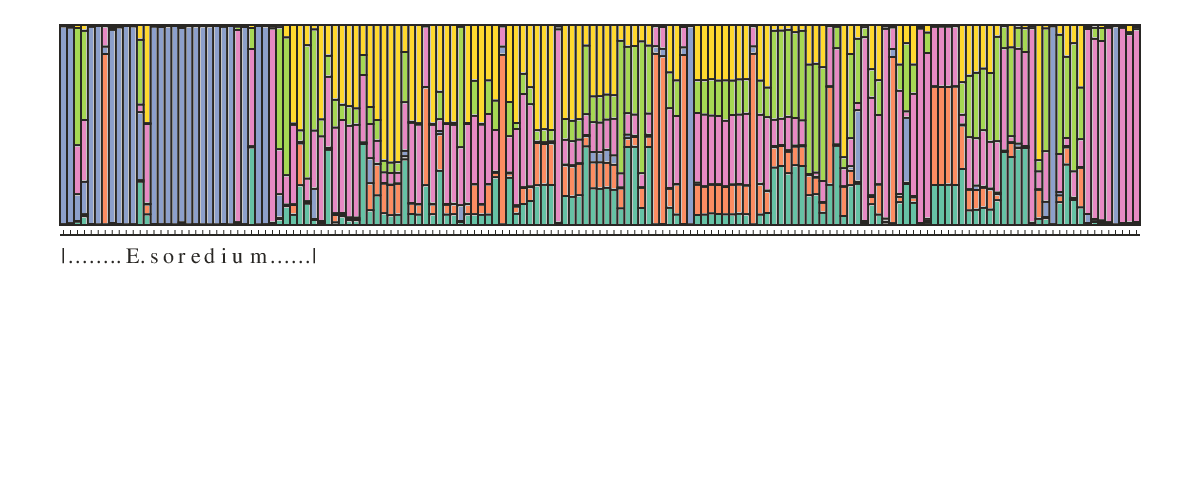

In [77]:
## further styling of plot with css 
style = {"stroke":toyplot.color.near_black, 
         "stroke-width": 2}

## build barplot
canvas = toyplot.Canvas(width=1200, height=500)
axes = canvas.cartesian(bounds=("5%", "95%", "5%", "45%"))
axes.bars(table, title=hover(table), style=style)

## add names to x-axis
ticklabels = [i for i in table.index.tolist()]
axes.x.ticks.locator = toyplot.locator.Explicit(labels=my_sored)
axes.x.ticks.labels.angle = 0
axes.x.ticks.show = True
axes.x.ticks.labels.offset = 10
axes.x.ticks.labels.style = {"font-size": "22px"}
axes.x.ticks.labels.style = {"font-family": "times"}
axes.x.spine.style = style
axes.y.show = False
    
## options: uncomment to save plots. Only html retains hover.
import toyplot.svg
import toyplot.pdf
import toyplot.html
#toyplot.svg.render(canvas, "struct.svg")
toyplot.pdf.render(canvas, "struct6.pdf")
#toyplot.html.render(canvas, "struct.html")

## show in notebook
canvas

### Calculating the best K 
I haven't gotten around to writing the code for this yet (contributors are welcome!). For now, I like using the site http://taylor0.biology.ucla.edu/structureHarvester/. It's great. Super easy. Zip up all the files in our structure directory, submit them to the site, and you're done. 

In [ ]:
%%bash -s "$STRUCTDIR"

## creates zip dir of all files ending with _f
zip structure-files-K2and3.zip *_f

### Copying this notebook to your computer/cluster
You can easily copy this notebook and then just replace my file names with your filenames to run your analysis. Just click on the [Download Notebook] link at the top of this page. Then run `jupyter-notebook` from a terminal and open this notebook from the dashboard.